# Q2 - Weather Recognition

## 1. Import Libraries 

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import shutil

## 2. Data Preparation

In [27]:
# Data directory
data_dir = '../Data_Q2/train_data'

# List of folder names corresponding to different weather conditions
folders = ['Cloudy', 'Foggy', 'Rainy', 'Snowy', 'Sunny']

# Create directories for each weather condition if they don't exist
for folder_name in folders:
    folder_path = os.path.join(data_dir, folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

# Move files to corresponding weather condition folders
for filename in os.listdir(data_dir):
    # Check if the item in the data directory is a file
    if os.path.isfile(os.path.join(data_dir, filename)):  
        # Loop through each folder name to find a matching condition in the filename
        for folder_name in folders:
            # If the folder name is part of the filename
            if folder_name in filename:
                # Define the source and destination paths for the file
                source_path = os.path.join(data_dir, filename)
                destination_path = os.path.join(data_dir, folder_name, filename)
                # Move the file from the source to the destination path
                shutil.move(source_path, destination_path)


## 3. Data Loading

In [28]:
# Image size and batch size settings
image_size = (224, 224)
batch_size = 32

# Initialize ImageDataGenerator with rescaling
datagen = ImageDataGenerator(rescale=1./255)

# Load images from directory
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')


Found 250 images belonging to 5 classes.


## 4. Model Building

In [29]:
# Define the vgg16 model

def build_vgg16(input_shape=(224, 224, 3), num_classes=5):
    # Define the input
    input_tensor = Input(shape=input_shape)

    # First block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_tensor)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Second block
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Third block
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Fourth block
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Fifth block
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Flatten and Dense layers
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=input_tensor, outputs=x)
    return model

In [30]:
# Build the model
model = build_vgg16()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 128)     147584    
                                                           

## 5. Model Training

In [31]:
# Train the model
history = model.fit(train_generator, epochs=50)

Epoch 1/50
8/8 [==============================] - 50s 6s/step - loss: 1.6122 - accuracy: 0.1800
Epoch 2/50
8/8 [==============================] - 47s 6s/step - loss: 1.6047 - accuracy: 0.2080
Epoch 3/50
8/8 [==============================] - 46s 6s/step - loss: 1.5950 - accuracy: 0.2520
Epoch 4/50
8/8 [==============================] - 46s 6s/step - loss: 1.5811 - accuracy: 0.3360
Epoch 5/50
8/8 [==============================] - 48s 6s/step - loss: 1.4498 - accuracy: 0.3840
Epoch 6/50
8/8 [==============================] - 47s 6s/step - loss: 1.3392 - accuracy: 0.4200
Epoch 7/50
8/8 [==============================] - 47s 6s/step - loss: 1.2662 - accuracy: 0.3800
Epoch 8/50
8/8 [==============================] - 48s 6s/step - loss: 1.3481 - accuracy: 0.3920
Epoch 9/50
8/8 [==============================] - 46s 6s/step - loss: 1.2154 - accuracy: 0.4600
Epoch 10/50
8/8 [==============================] - 47s 6s/step - loss: 1.1537 - accuracy: 0.4720
Epoch 11/50
8/8 [======================

## 6. Model Evaluation

In [32]:
# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(train_generator)
print("Accuracy on training set:", train_accuracy)

8/8 [==============================] - 13s 2s/step - loss: 0.0312 - accuracy: 0.9920
Accuracy on training set: 0.9919999837875366


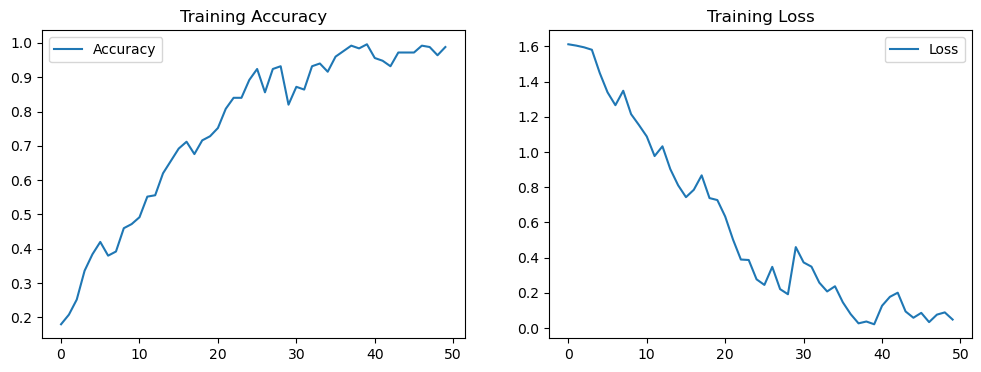

In [33]:
import matplotlib.pyplot as plt

# Plot the training accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss')
plt.legend()
plt.show()